<a href="https://colab.research.google.com/github/Maks6666/ML/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [9]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про розпад протонів

[посилання](https://www.kaggle.com/datasets/fedesoriano/multijet-primary-dataset)

In [6]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/MultiJetRun2010B.csv')

df = df[df['nBJets'] != 2]

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані погано збалансовані

In [7]:
df['nBJets'].value_counts()

,count
nBJets,
0,20615
1,1056


In [8]:
df.head()

,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,0.082072,0.0,0.000002,0.077191,0.041860,0.044618,0.342725,0.531326,0.480732,0.055588,0.696681,0.457241,0.440224,0.061659,0.043047,0.0,0
1,0.082072,0.0,0.000006,0.052182,0.055190,0.018690,0.493614,0.585784,0.491979,0.017684,0.567978,0.430552,0.474613,0.025133,0.034687,0.0,0
2,0.082072,0.0,0.000015,0.154156,0.035263,0.101251,0.540018,0.671386,0.470196,0.273968,0.533484,0.338381,0.325311,0.165718,0.059381,0.2,0
3,0.082072,0.0,0.000048,0.106599,0.123328,0.063472,0.306290,0.523352,0.483465,0.039306,0.713922,0.422854,0.493248,0.101707,0.108566,0.0,0
4,0.082072,0.0,0.000063,0.072599,0.024611,0.383563,0.508826,0.564737,0.292545,0.224039,0.550834,0.433906,0.361549,0.110721,0.018941,0.2,0


In [13]:
X = df.drop("nBJets", axis="columns")
y = df["nBJets"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Потрібно на основі інформації про розпад спрогнозувати наявність високоенергетичного випромінювання `nBJets`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [11]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X.values).to(device)
    self.y = torch.FloatTensor(y.values).to(device)
    self.y = self.y.reshape(-1, 1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [14]:
train_ds = MyDataset(X_train, y_train)
test_ds = MyDataset(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [15]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, generator=torch.Generator(device=device))
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True, generator=torch.Generator(device=device))

In [16]:
device

'cuda'

In [22]:
train_ds[0][0].shape

torch.Size([16])

# Завдання 3
Створіть нейромережу

In [53]:
from torch import nn
import torch.nn.functional as F


class Model(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()

    self.linear_1 = nn.Linear(input_dim, hidden_dim)
    self.bnorm_1 = nn.BatchNorm1d(hidden_dim)
    self.drop_out1 = nn.Dropout(0.1)
    self.linear_2 = nn.Linear(hidden_dim, hidden_dim-7)
    self.linear_3 = nn.Linear(hidden_dim-7, hidden_dim-10)
    self.linear_4 = nn.Linear(hidden_dim-10, hidden_dim-18)
    self.linear_5 = nn.Linear(hidden_dim-18, hidden_dim-21)
    self.linear_6 = nn.Linear(hidden_dim-21, output_dim)

  def forward(self, x):
    out = self.linear_1(x)
    out = self.bnorm_1(out)
    out = F.relu(out)
    out = self.drop_out1(out)
    out = self.linear_2(out)
    out = F.relu(out)
    out = self.linear_3(out)
    out = F.relu(out)
    out = self.linear_4(out)
    out = F.relu(out)
    out = self.linear_5(out)
    out = F.relu(out)
    out = self.linear_6(out)

    return out

  def predict(self, X, device="cpu"):
    X = torch.FloatTensor(X.values).to(device)

    with torch.no_grad():
      y_pred = self.forward(X)
      y_pred = F.sigmoid(y_pred)

    return y_pred.cpu().numpy().squeeze()

model = Model(16, 27, 1)
model


Model(
  (linear_1): Linear(in_features=16, out_features=27, bias=True)
  (bnorm_1): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out1): Dropout(p=0.1, inplace=False)
  (linear_2): Linear(in_features=27, out_features=20, bias=True)
  (linear_3): Linear(in_features=20, out_features=17, bias=True)
  (linear_4): Linear(in_features=17, out_features=9, bias=True)
  (linear_5): Linear(in_features=9, out_features=6, bias=True)
  (linear_6): Linear(in_features=6, out_features=1, bias=True)
)

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [47]:
y_train.value_counts()

,count
nBJets,
0,16506
1,830


In [39]:
num_0 = sum(y_train == 0)
num_1 = sum(y_train == 1)

loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(num_0/num_1))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)

In [55]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

# Завдання 5
Натренуйте нейромережу.

In [48]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = F.sigmoid(y_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        scheduler.step()
        history['lr'].append(scheduler.get_last_lr())


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                y_pred = F.sigmoid(y_pred)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [56]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_func, train_dl, test_dl,
                epochs=120,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')

train() called: model=Model, opt=Adam(lr=0.000000), epochs=120, device=cuda

Epoch    1    1sec	loss:       1.32	val_loss:       1.37	accuracy_score:     0.0479	val_accuracy_score:     0.0521	roc_auc_score:      0.537	val_roc_auc_score:      0.477	
Epoch    2    1sec	loss:       1.32	val_loss:       1.37	accuracy_score:     0.0479	val_accuracy_score:     0.0521	roc_auc_score:      0.536	val_roc_auc_score:      0.478	
Epoch    3    1sec	loss:       1.32	val_loss:       1.37	accuracy_score:     0.0479	val_accuracy_score:     0.0521	roc_auc_score:      0.545	val_roc_auc_score:      0.466	
Epoch    4    1sec	loss:       1.32	val_loss:       1.37	accuracy_score:     0.0479	val_accuracy_score:     0.0521	roc_auc_score:      0.548	val_roc_auc_score:      0.474	
Epoch    5    1sec	loss:       1.32	val_loss:       1.37	accuracy_score:     0.0479	val_accuracy_score:     0.0521	roc_auc_score:      0.538	val_roc_auc_score:      0.478	
Epoch    6    1sec	loss:       1.32	val_loss:       1.37	accura

KeyboardInterrupt: 

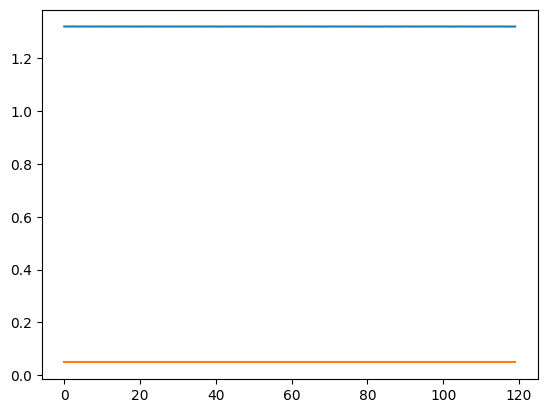

In [52]:
import matplotlib.pyplot as plt

plt.plot(history["loss"])
plt.plot(history["accuracy_score"])

# Завдання 6
Збережіть нейромережу та зробіть прогноз